In [74]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd

In [40]:
def y(t,a,w,phi,tau):
    return 50+np.heaviside(t,0)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))
    


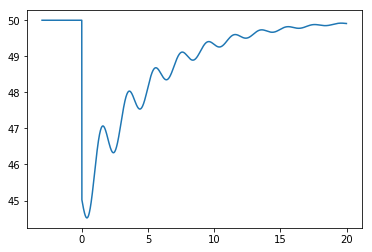

In [49]:
t = np.arange(-3,20,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))

In [212]:
t_sim     =  np.random.rand(10*len(t))*23-3
e_sim     =  np.random.normal(916,3,len(t_sim))
y_sim     =  y(t_sim,1,np.pi,3.1,5) #+np.random.normal(0,1,len(t_sim))
IFEE_sim  =  np.random.rand(len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(913-e_sim)**2/4**2)+np.random.normal(0.3,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim * (e_sim-895) +np.random.normal(.0001,1,len(t_sim))**2

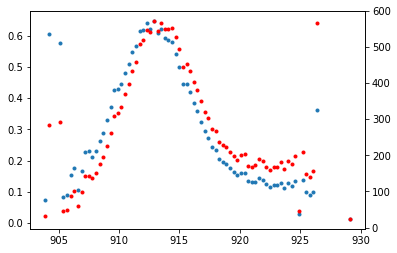

In [213]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic_dd(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1)
plt.twinx()
my_binned_stat = binned_statistic_dd(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1,color='r')

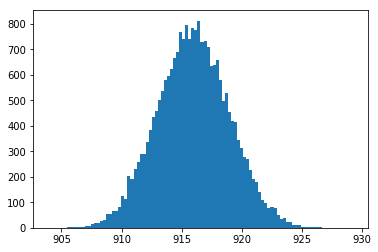

In [214]:
dummy_hist = plt.hist(e_sim,bins=100)

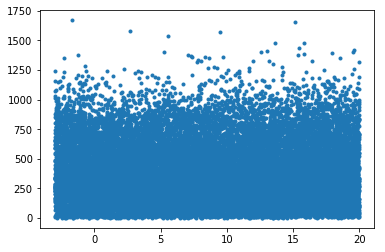

In [215]:
plt.plot(t_sim,I_sim,'.')
plt.show()

In [216]:
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    my_pump_probe.append(beta)

In [217]:
my_pump_probe = np.array(my_pump_probe)

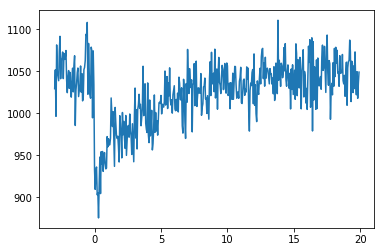

In [218]:
plt.plot(t_bins[:-1],my_pump_probe[:,1])

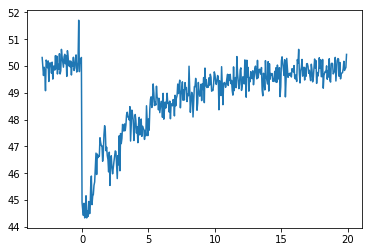

In [219]:
plt.plot(t_bins[:-1],my_pump_probe[:,3])